# Generate traffic - Simulate traffic your application would recieve

In this notebook we are going to generate some traffic to the endpoint, part of which will be sent for review by human reviewers



In [ ]:
import boto3
import json
import uuid

# endpoint_name = "<<ENTER GIVEN ENDPOINT NAME>>"
endpoint_name = "DEMO-endpoint-sentiment-analysis"
flowDefinitionArn = "<<ENTER FLOW DEFINITION ARN>>"

runtime = boto3.client(service_name="sagemaker-runtime")
a2i_runtime_client = boto3.client('sagemaker-a2i-runtime')
client = boto3.client(service_name="sagemaker")


if flowDefinitionArn == "<<ENTER FLOW DEFINITION ARN>>":
    flowDefinitionArn = client.list_flow_definitions(SortOrder='Descending')['FlowDefinitionSummaries'][0]['FlowDefinitionArn']
    print("flowDefinitionArn was not provided, using the most recently created one")
    print(flowDefinitionArn)

if endpoint_name=="<<ENTER GIVEN ENDPOINT NAME>>":
    endpoint_name = client.list_endpoints(SortOrder='Descending')['Endpoints'][0]['EndpointName']
    print("Endpoint name not provided, using the most recently created one")
    print(endpoint_name)

## Creating and Starting A2I human loop 
For more information https://docs.aws.amazon.com/sagemaker/latest/dg/a2i-start-human-loop.html#a2i-instructions-starthumanloop

When using Amazon A2I for a custom task, a human loops starts when StartHumanLoop is called in your application. 

<br><br>
In the following blocks we define 3 functions.

`make_prediction` - This function is responsible for calling our endpoint. Given a sentence, this function will return the prediction made by our model

`check_for_human_review` - This function evaluates if the given prediction needs to pass through a human to review. If it does, then it starts an A2I human loop

`e2e_prediction` - This function executes the above two functions one after the other

<br>

In [ ]:
def make_prediction(sentence="I love using the new Serverless Inference on SageMaker."):
    sentiment_input = {"inputs": sentence}

    response = runtime.invoke_endpoint(
        EndpointName=endpoint_name,
        Body=json.dumps(sentiment_input),
        ContentType="application/json",
    )

    result = json.loads(response['Body'].read().decode())
    p = "Positive" if result[0]['label'] == "LABEL_1" else "Negative"
    score = result[0]['score']
    return p, score


sentence="I love using the new Real-time Inference on SageMaker."
p, score = make_prediction(sentence)
response = {}
response['utterance']=sentence
response['prediction']= p
response['confidence'] = score
print(response)

In [ ]:
human_loops_started = []
CONFIDENCE_SCORE_THRESHOLD = .70

def check_for_human_review(response):
    if(response['confidence'] < CONFIDENCE_SCORE_THRESHOLD):
        humanLoopName = str(uuid.uuid4())
        human_loop_input = {}

        human_loop_input['taskObject'] = response['utterance']
        start_loop_response = a2i_runtime_client.start_human_loop(
            HumanLoopName=humanLoopName,
            FlowDefinitionArn=flowDefinitionArn,
            HumanLoopInput={
                    "InputContent": json.dumps(human_loop_input)
                }
        )
#             print(human_loop_input)
        human_loops_started.append(humanLoopName)
        print(f"Model is thinking that sentence is: {response['prediction']} but will ask a human to verify")
        print(f"Score is {response['confidence']} which is less than the threshold of {CONFIDENCE_SCORE_THRESHOLD}")
        print(f'Starting human loop with name: {humanLoopName}  \n')
    else:
        print(f"Model is sure that sentence is: {response['prediction']}")
        print('No human loop created. \n')

In [ ]:
def e2e_prediction(sentence):
    p, score = make_prediction(sentence)
    response = {}
    response['utterance']=sentence
    response['prediction']= p
    response['confidence'] = score
    
    check_for_human_review(response)

## Make end-to-end predictions 
The following simulates example sentences that your application is receiving. When needed, a sentence is sent for human review. 

Feel free to add your own example sentences in the `sentence_list` variable. 

Once you run this, navigate to the A2I reviewer portal and start annotating the sentences that your model is unsure of.

In [ ]:
sentences_list = [
    "I have learnt a lot in this NLP Summit, it's has been amazing!",
    "I hate the commute to London",
    "I am not sure how this Human In the Loop concept works",
    "I think I now understand it, it's great!"
]

for sentence in sentences_list:
    print("======================================")
    e2e_prediction(sentence)
    print("======================================\n")
    

## Navigate to the reviewer portal and start labelling the jobs that were just started. 
At this point, feel free to change the sentences in the `sentence_list` variable above and rerun the cell to make predictions and generate further human reviews. 

<br>
If at least one of the above sentences resulted in a human review to start, you can navigate to the portal, refresh the page, and it should look like the below. Click on "Start Working" and start labelling!


![3-reviews-available.png](images/3-reviews-available.png)

Once you start work, you should be seeing a UI similar to the below, containing the sentences that you added

![3-first-reviews.png](images/3-first-reviews.png)
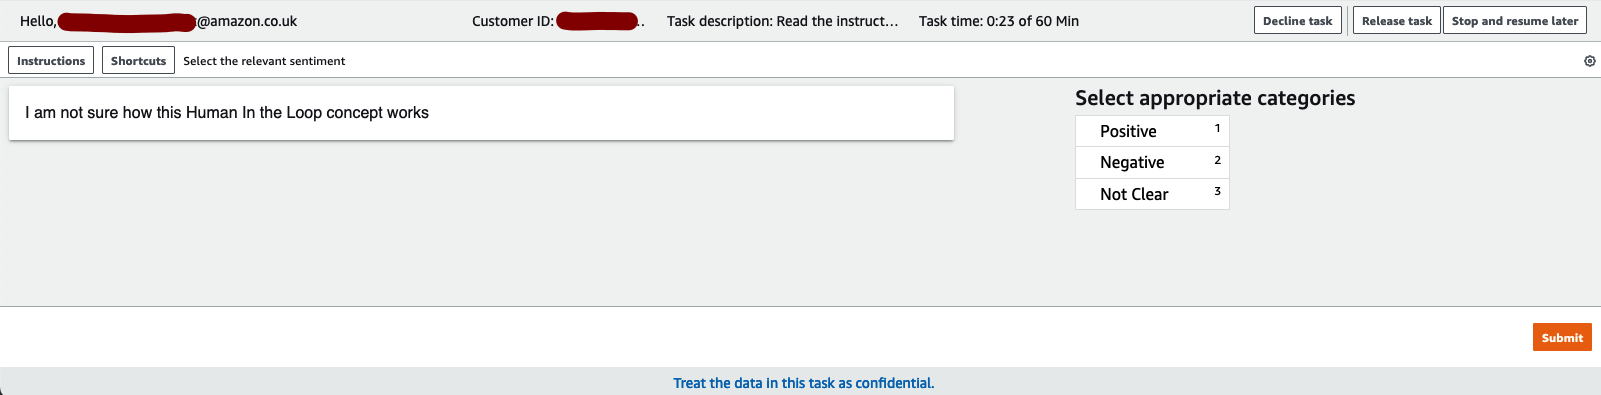
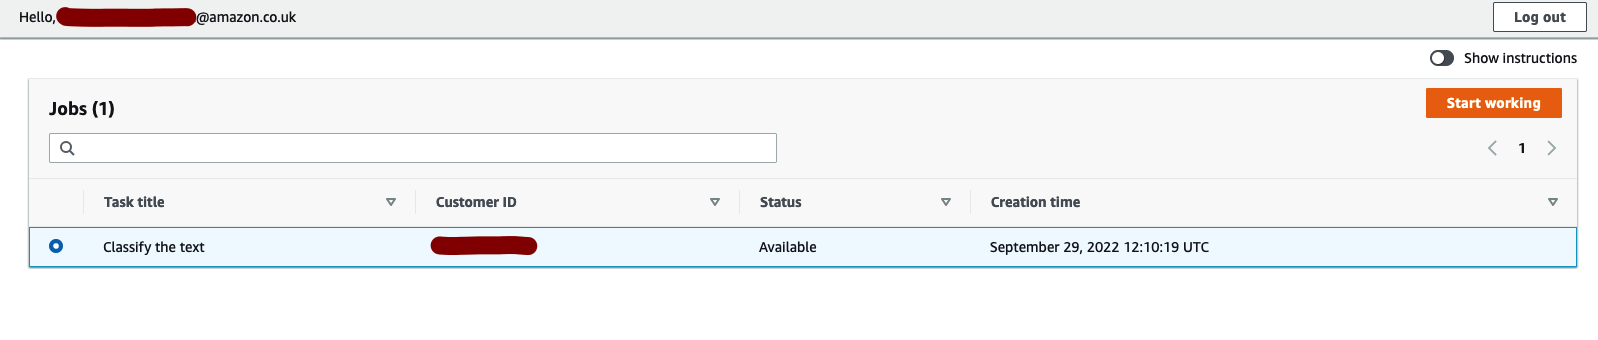

# Display status of the Human Loop
Below you can check the status of the human loops and if reviews have happened. Keep in mind that this process is very asynchronous by nature, so in real life applications your reviewers make take minutes, hours or even days to annotate the data.

## Check the status of human loops if the workers have completed labelling

In [ ]:
completed_human_loops = []
for human_loop_name in human_loops_started:
    resp = a2i_runtime_client.describe_human_loop(HumanLoopName=human_loop_name)
    print(f'HumanLoop Name: {human_loop_name}')
    print(f'HumanLoop Status: {resp["HumanLoopStatus"]}')
    print(f'HumanLoop Output Destination: {resp["HumanLoopOutput"]}')
    print('\n')
    
    if resp["HumanLoopStatus"] == "Completed":
        completed_human_loops.append(resp)


## Review the labelling results in Amazon S3


In [ ]:
for completed_human_loop in completed_human_loops:
    response = completed_human_loop["HumanLoopOutput"]["OutputS3Uri"]
    bucket = response.split("/")[2]    
    key = response.split("/",3)[3]    
    
    s3 = boto3.client('s3')

    s3obj = s3.get_object(Bucket=bucket, Key=key)
    s3data = s3obj['Body'].read().decode('utf-8')
    abc = json.loads(s3data)
    print("======================================")
    print(json.dumps(abc, indent=4, sort_keys=True))
    print("======================================\n")

    